In [1]:
import pandas as pd
import plotly.offline as offline
offline.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from datetime import datetime


first_day = "25.10.2022"
last_day = "01.05.2024"
startDate = datetime.strptime(first_day, '%d.%m.%Y')
endDate = datetime.strptime(last_day, '%d.%m.%Y')
years = range(startDate.year,endDate.year+1)
days_in_year = pd.Series(pd.date_range("2000", freq="D", periods=366)).dt.strftime('%d.%m').values

# Elektrika 

In [2]:
#import csv
csvs = []
for i,year in enumerate(years):
    csv = pd.read_csv('data/elektro-'+str(year)+'.csv',parse_dates=["Datum"])
    csv.index = pd.DatetimeIndex(csv['Datum'])
    #dates in year
    start_date_range = datetime.strptime(str(year), '%Y')
    end_date_range = datetime.strptime(str(year+1), '%Y')
    if (year == startDate.year): 
        start_date_range = startDate    
    if (year == endDate.year): 
        end_date_range = endDate
    #all the dates within year
    idx = pd.date_range(start_date_range, end_date_range, freq="D",inclusive="left")
    csv = csv.reindex(idx)
    csv['Datum'] = csv.index
    csv = csv.reset_index(drop=True)
    csv['Datum'] = pd.to_datetime(csv['Datum'])
    csvs.append(csv)
#csv[0].dtypes

In [3]:
#interpolated
csvs_filled = []
for csv in csvs:
    csvs_filled.append(csv.interpolate())

## Pridelava elektrike

### ...po dnevih

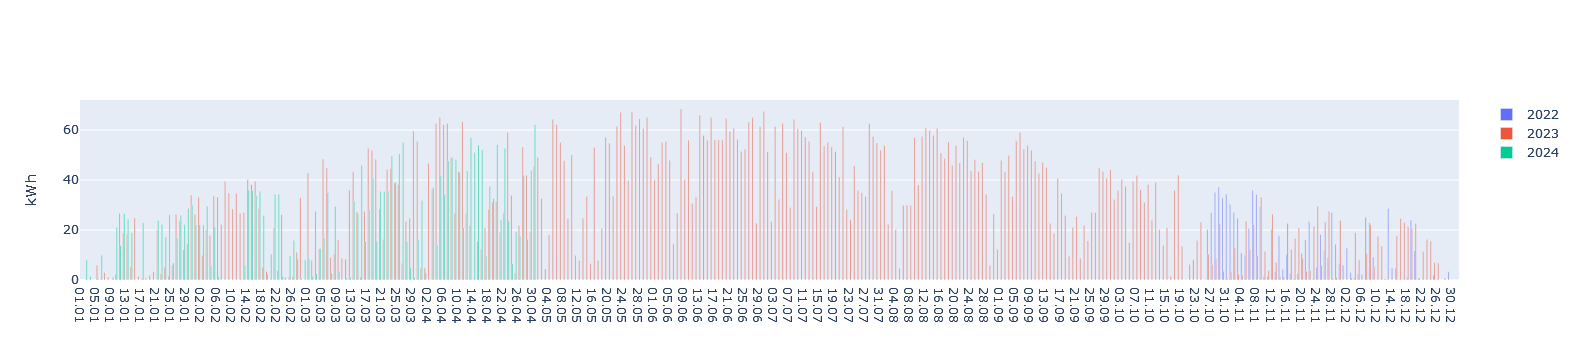

In [4]:
fig = go.Figure()
for i,csv in enumerate(csvs_filled):
    oddana_per_day = csv['ODDANA DELOVNA ENERGIJA ET'] - csv['ODDANA DELOVNA ENERGIJA ET'].shift(1, fill_value=csv['ODDANA DELOVNA ENERGIJA ET'][0]);
    fig.add_traces(go.Bar(name=str(years[i]), x=csv['Datum'].dt.strftime('%d.%m'), y = oddana_per_day))

fig.update_layout(barmode='group')
fig.update_xaxes(categoryorder='array', categoryarray=days_in_year)
fig.update_layout(hovermode='x unified', yaxis=dict(title="kWh"))

fig.show()

### ...skupno

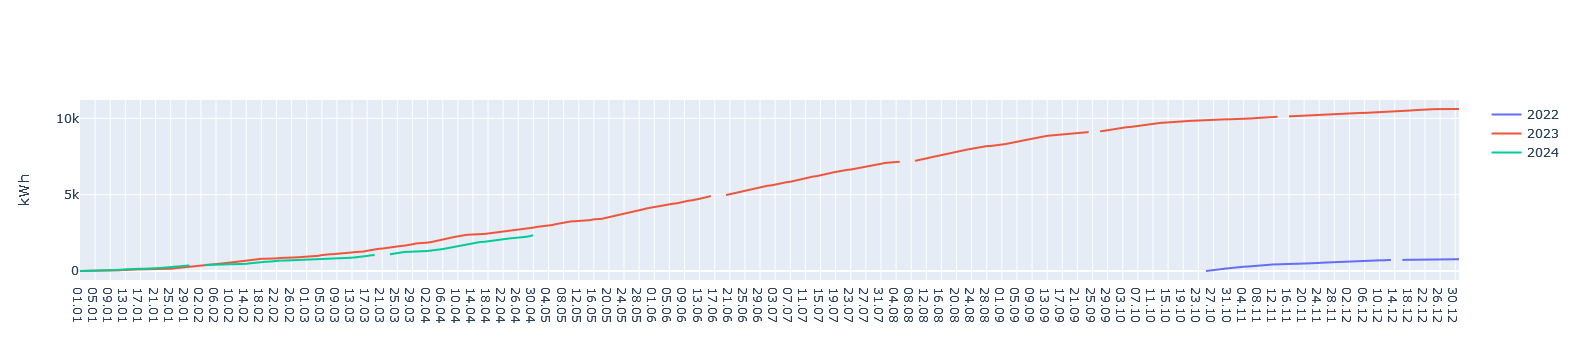

In [5]:
fig = go.Figure()
for i,csv in enumerate(csvs):
    skupna_oddana_letno = (csv['ODDANA DELOVNA ENERGIJA ET'] - csv['ODDANA DELOVNA ENERGIJA ET'].shift(1, fill_value=csv['ODDANA DELOVNA ENERGIJA ET'][0])).cumsum();
    fig.add_traces(go.Scatter(name=str(years[i]), x=csv['Datum'].dt.strftime('%d.%m'), y = skupna_oddana_letno))

fig.update_xaxes(categoryorder='array', categoryarray=days_in_year)
fig.update_layout(hovermode='x unified', yaxis=dict(title="kWh"))
fig.show()

## Poraba elektrike

### ...po dnevih

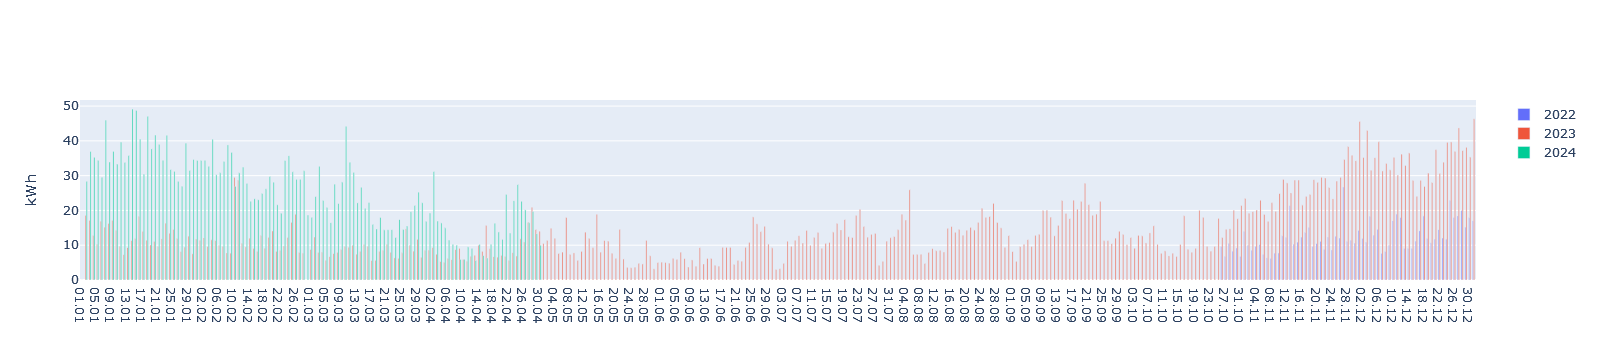

In [6]:
fig = go.Figure()
for i,csv in enumerate(csvs_filled):
    poraba_per_day = csv['PREJETA DELOVNA ENERGIJA ET'] - csv['PREJETA DELOVNA ENERGIJA ET'].shift(1, fill_value=csv['PREJETA DELOVNA ENERGIJA ET'][0]);
    fig.add_traces(go.Bar(name=str(years[i]), x=csv['Datum'].dt.strftime('%d.%m'), y = poraba_per_day))

fig.update_layout(barmode='group')
fig.update_xaxes(categoryorder='array', categoryarray=days_in_year)
fig.update_layout(hovermode='x unified', yaxis=dict(title="kWh"))
fig.show()

### ...skupno

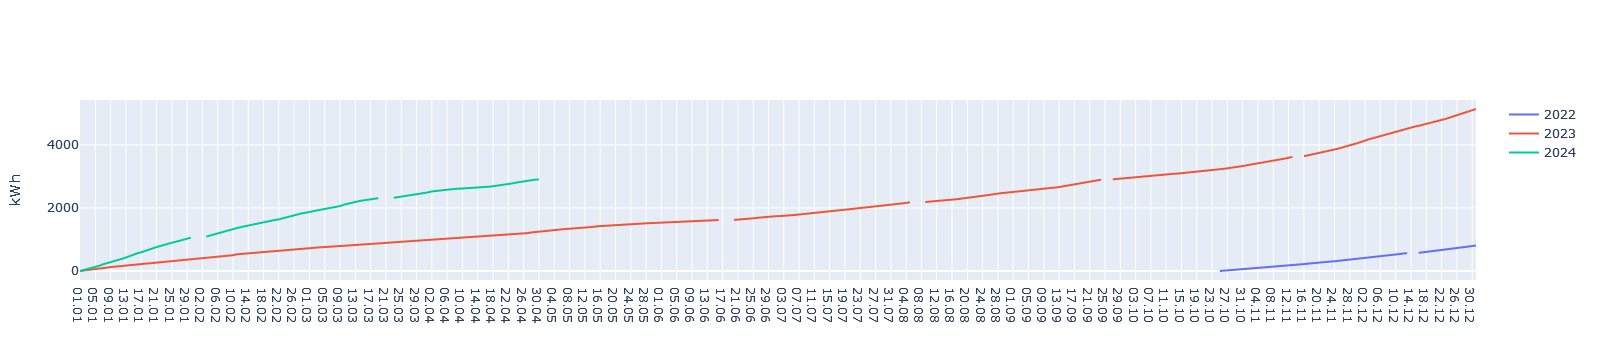

In [7]:
fig = go.Figure()
for i,csv in enumerate(csvs):
    skupna_poraba_letno = (csv['PREJETA DELOVNA ENERGIJA ET'] - csv['PREJETA DELOVNA ENERGIJA ET'].shift(1, fill_value=csv['PREJETA DELOVNA ENERGIJA ET'][0])).cumsum();
    fig.add_traces(go.Scatter(name=str(years[i]), x=csv['Datum'].dt.strftime('%d.%m'), y = skupna_poraba_letno))

fig.update_xaxes(categoryorder='array', categoryarray=days_in_year)
fig.update_layout(hovermode='x unified', yaxis=dict(title="kWh"))
fig.show()

## Presek porabe in odjema

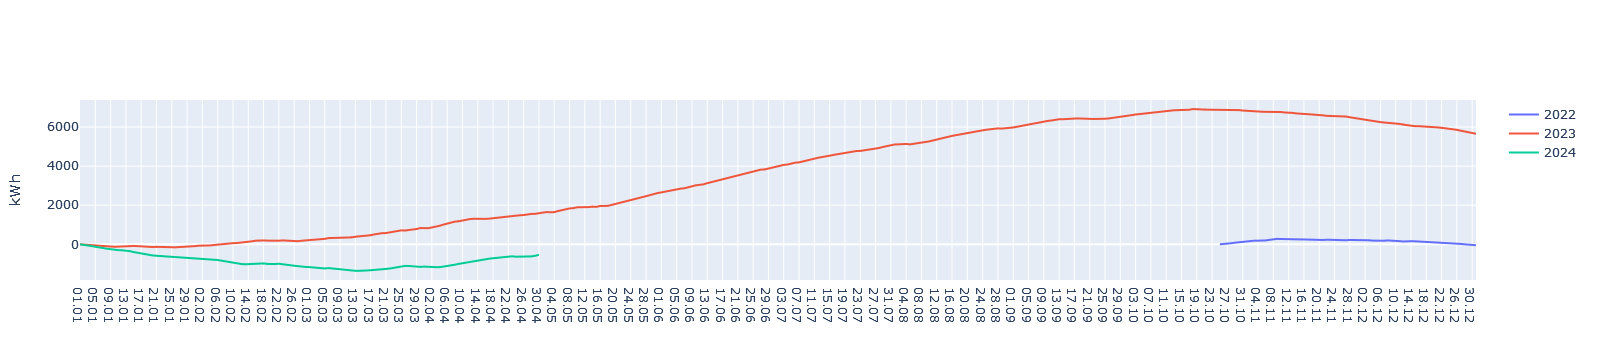

In [8]:
fig = go.Figure()
for i,csv in enumerate(csvs_filled):
    skupna_poraba_letno = (csv['PREJETA DELOVNA ENERGIJA ET'] - csv['PREJETA DELOVNA ENERGIJA ET'].shift(1, fill_value=csv['PREJETA DELOVNA ENERGIJA ET'][0])).cumsum();
    skupna_oddana_letno = (csv['ODDANA DELOVNA ENERGIJA ET'] - csv['ODDANA DELOVNA ENERGIJA ET'].shift(1, fill_value=csv['ODDANA DELOVNA ENERGIJA ET'][0])).cumsum();
    pm = skupna_oddana_letno - skupna_poraba_letno
    
    fig.add_trace(go.Scatter(x=csv['Datum'].dt.strftime('%d.%m'), y = pm, name=str(years[i])))

fig.update_xaxes(categoryorder='array', categoryarray=days_in_year)
fig.update_layout(hovermode='x unified', yaxis=dict(title="kWh"))
fig.show()

### Dnevno po letih

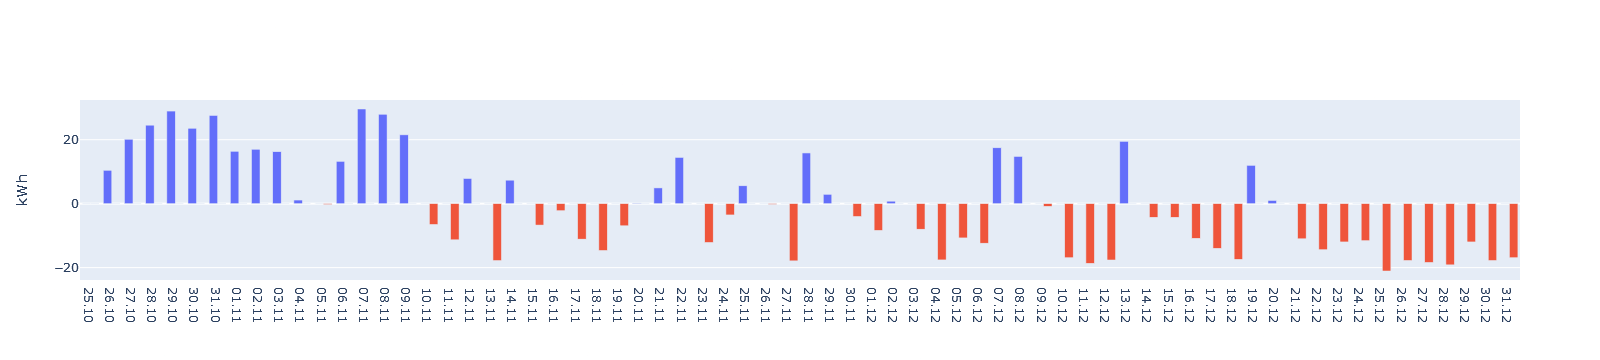

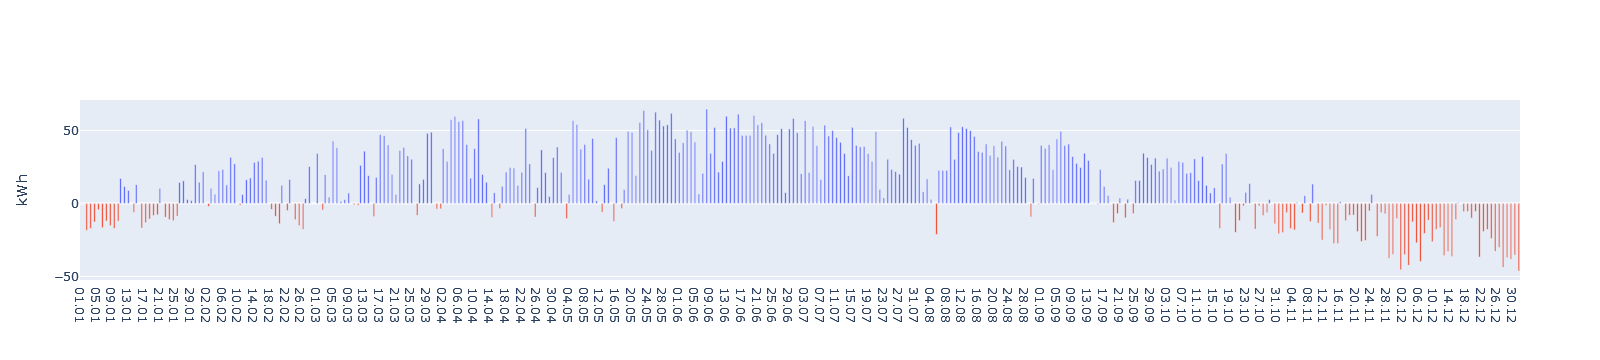

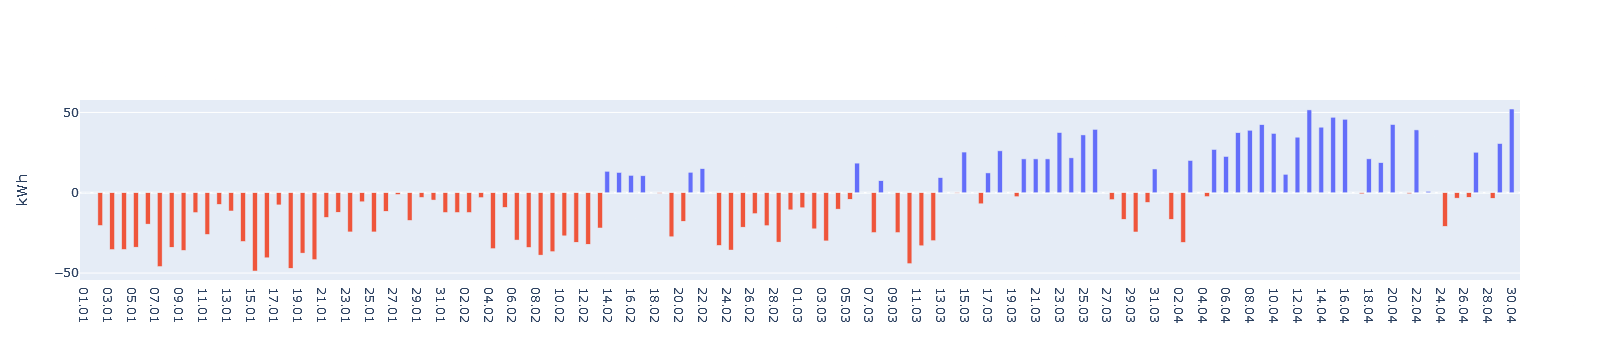

In [9]:
for i,csv in enumerate(csvs_filled):
    prejeta_per_day = csv['PREJETA DELOVNA ENERGIJA ET'] - csv['PREJETA DELOVNA ENERGIJA ET'].shift(1, fill_value=csv['PREJETA DELOVNA ENERGIJA ET'][0]);
    oddana_per_day = csv['ODDANA DELOVNA ENERGIJA ET'] - csv['ODDANA DELOVNA ENERGIJA ET'].shift(1, fill_value=csv['ODDANA DELOVNA ENERGIJA ET'][0]);
    
    pm = oddana_per_day - prejeta_per_day
    
    mask = pm >= 0
    plus = np.where(mask, pm, 0)
    minus = np.where(mask, 0, pm)
    
    fig = go.Figure()
    fig.add_traces(go.Bar(x=csv['Datum'].dt.strftime('%d.%m'), y = plus, name=""))
    fig.add_traces(go.Bar(x=csv['Datum'].dt.strftime('%d.%m'), y = minus, name=""))
    fig.update_xaxes(categoryorder='array', categoryarray=days_in_year)
    fig.update_layout(hovermode='x unified',showlegend=False, yaxis=dict(title="kWh"))
    fig.show()

### Skupno po letih

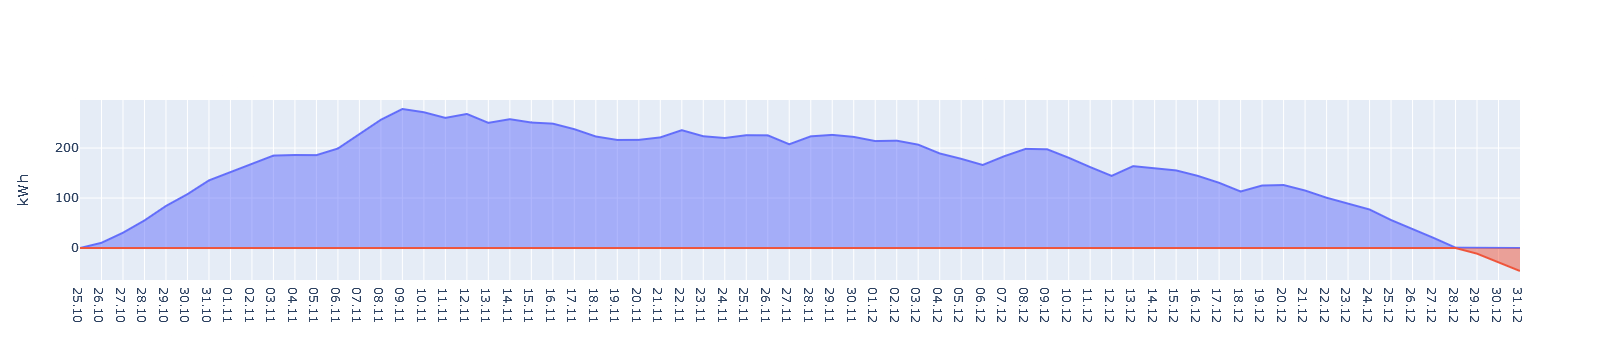

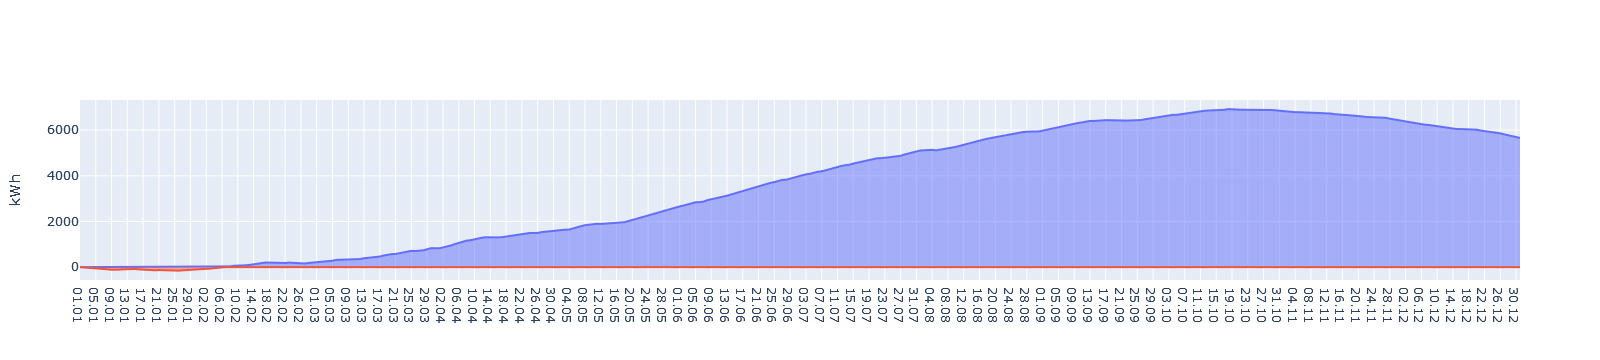

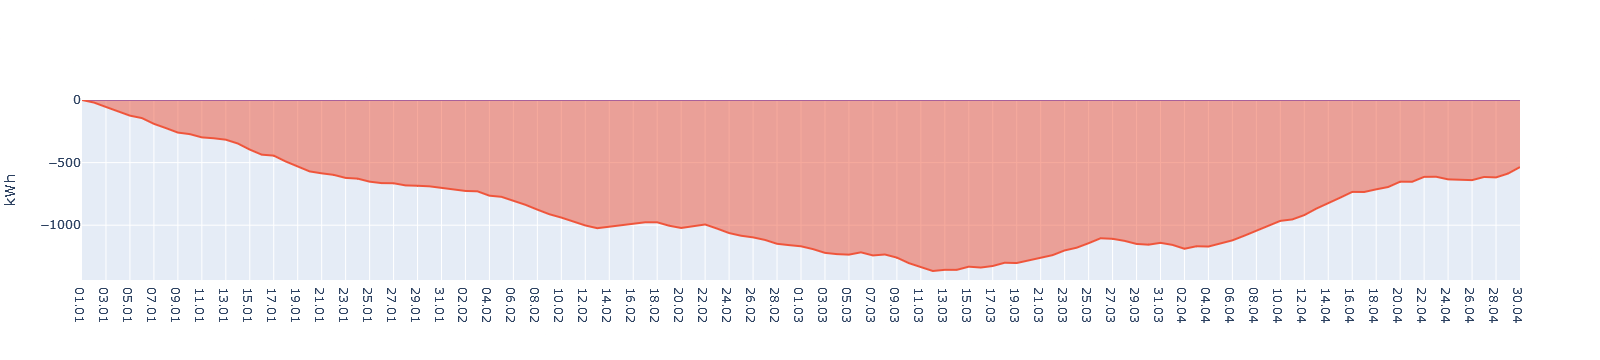

In [10]:
for i,csv in enumerate(csvs_filled):
    skupna_poraba_letno = (csv['PREJETA DELOVNA ENERGIJA ET'] - csv['PREJETA DELOVNA ENERGIJA ET'].shift(1, fill_value=csv['PREJETA DELOVNA ENERGIJA ET'][0])).cumsum();
    skupna_oddana_letno = (csv['ODDANA DELOVNA ENERGIJA ET'] - csv['ODDANA DELOVNA ENERGIJA ET'].shift(1, fill_value=csv['ODDANA DELOVNA ENERGIJA ET'][0])).cumsum();

    pm = skupna_oddana_letno - skupna_poraba_letno
    
    mask = pm >= 0
    plus = np.where(mask, pm, 0)
    minus = np.where(mask, 0, pm)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=csv['Datum'].dt.strftime('%d.%m'), y = plus, fill='tozeroy', name=""))
    fig.add_trace(go.Scatter(x=csv['Datum'].dt.strftime('%d.%m'), y = minus, fill='tozeroy', name=""))
    fig.update_xaxes(categoryorder='array', categoryarray=days_in_year)
    fig.update_layout(hovermode='x unified',showlegend=False, yaxis=dict(title="kWh"))
    fig.show()